# Débruitage de Vuvuzela



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.io import wavfile
from IPython.display import Audio


## Introduction

### Contexte / Problématique

Lors de la coupe du Monde de Football 2010, les téléspectateurs du monde entier ont pu découvrir un instrument de musique d’Afrique du Sud : le Vuvuzela. Passé la phase d’étonnement, le son continu généré par cet instrument est rapidement devenu gênant lors de la diffusion des matchs ([youtube](https://www.youtube.com/watch?v=bKCIFXqhLzo)). Dans ce projet, nous allons mettre en place un filtre "anti-vuvuzela" pour atténuer les sonorités de cet instrument.

<figure style="padding:40px;align:center">
<img style="width: 400px" src="https://i.dailymail.co.uk/i/pix/2010/06/13/article-1286265-09FE0925000005DC-48_468x299.jpg">
</figure>

### Méthodologie

In [2]:
Fs,data = wavfile.read("./vuvuzela.wav")     #read wavefile
data = data/(1.1*max(abs(data)))               # normalisation
Audio(data,rate=Fs)

Le repo gitlab contient un enregistrement sonore nommé `vuvuzela.wav` dans le repertoire `wav`. Cet enregistrement a été réalisé lors d’un match de la coupe du monde 2010. Pour supprimer les sonorités de Vuvuzela, nous allons procéder de la manière suivante :

1. Analyse du contenu spectral du fichier `vuvuzela.wav`.
2. Analyse de différents "rejecteurs" avec Python :`
    * un filtre RLC,
    * un filtre Twin T passif,
    * un filtre Twin T actif.
3. Etude expérimentale d’un des deux filtres passifs :
    * Détermination expérimentale de la résistance interne d’une bobine et réglage de la résistance de
compensation à rajouter dans la branche capacitive du RLC.
    * Détermination expérimentale du coefficient d’amortissement du twin T passif par mesure de la
 bande rejetée à partir du déphasage entre les signaux d’entrée et de sortie.
4. Implémentation des différents Twin T actif nécessaires pour rejeter les différentes harmoniques du son à éliminer. Preuve sur LTspice.
5. Répartition des différentes cellules à câbler entre les différents groupes.
6. Câblage de la cascade et test de l’ensemble sur le signal audio fourni.

Pour chacune de ces étapes, vous devez rédiger un notebook Jupyter expliquant votre démarche et présentant vos différents résultats.

## Déroulement du Projet

### Analyse Spectrale


### Fonction Plot

In [3]:
def afficher(x,y, x_nom = "Temps [s]", y_nom="Amplification [V]"):
    plt.plot(t,data)
    plt.xlabel(x_nom)
    plt.ylabel(y_nom)
    plt.show()

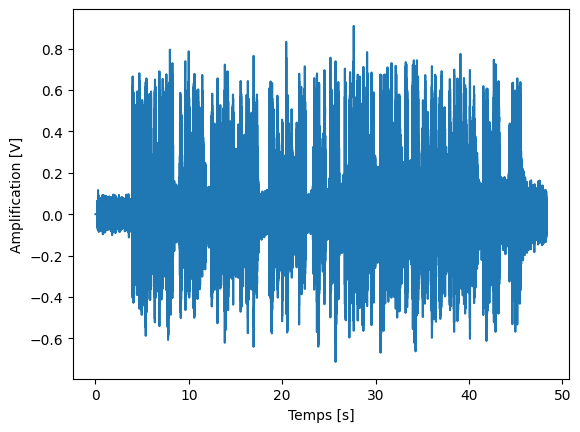

In [5]:
t = np.arange(len(data))/Fs        #convert sample index to time (in sec)plt.plot(t,data)
afficher(t,data)

La figure précédente affiche la représentation temporelle de l'enregistrement sonore à débruiter. Cet enregistrement contient des parties contenant uniquement les sonorités de Vuvuzela (entre 0 et 2s par exemple) et d'autres parties contenant les sonorités de Vuvuzela ainsi que des commentaires de journalistes sportifs.
Mathématiquement, les sonorités de Vuvuzela peuvent être modélisés par une somme de plusieurs sinusoïdes de fréquence $f_l$ c-a-d

$$x(t) = \sum_{l=1}^L a_l sin(2\pi f_l l t + \varphi_l)$$

Dans un premier temps, il est nécessaire de déterminer les fréquences $f_1$,$\cdots$, $f_L$ en réalisant une analyse spectrale (c-a-d fréquentielle) de l’enregistrement sonore. L'analyse pourra être réalisée en utilisant Python. Ccette partie nécessitera d’utiliser la fonctionnalité suivante :

* Estimation du spectre: [Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html)

**Question 1.** En utilisant `python`, représentez le contenu temporel puis fréquentiel de l'enregistrement sonore.

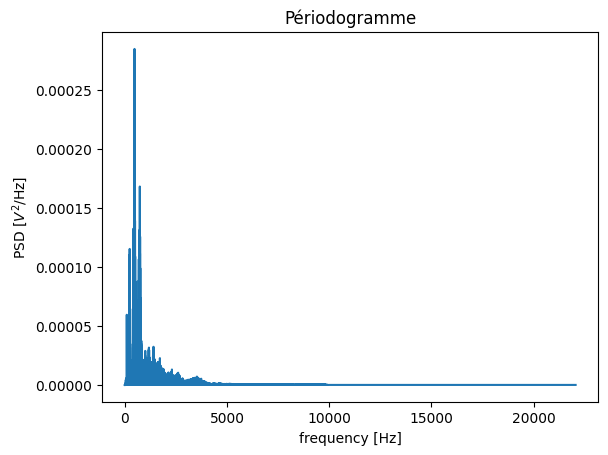

In [6]:
def periodogramme(samples,echantillonage):
    return signal.periodogram(samples, echantillonage)

def periodogramme_affichage(samples, echantillonage):
    f, Pxx_den = signal.periodogram(samples, echantillonage)
    plt.plot(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [$V^2$/Hz]')
    plt.title("Périodogramme")
    plt.show()

periodogramme_affichage(data,Fs)

**Question 2**. Isolez une portion temporelle de l’enregistrement sonore ne contenant que des sonorités de Vuvuzela (pas de commentaires sportifs). Représentez alors le contenu fréquentiel de cette portion.



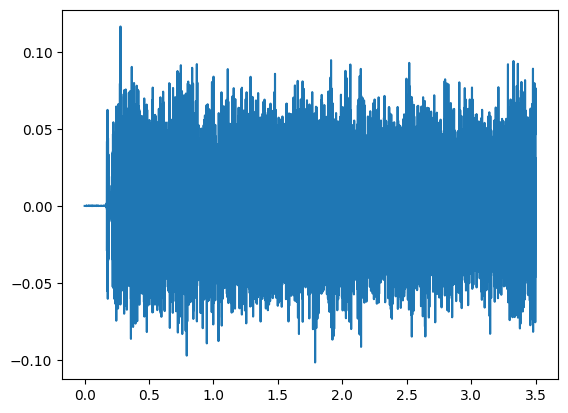

In [7]:
indice = [i for i in t].index(3.5)
t_vuvu = t[0:indice]
data_vuvu = data[0:indice]
plt.plot(t_vuvu, data_vuvu)

**Question 3.** Identifiez les composantes fréquentielles du son de Vuvuzela c-a-d les valeurs de $f_l$ ($k = 1,\cdots,L$). Retrouvez alors l'unique note de la gamme tempérée qu'est capable de générer le Vuvuzela.

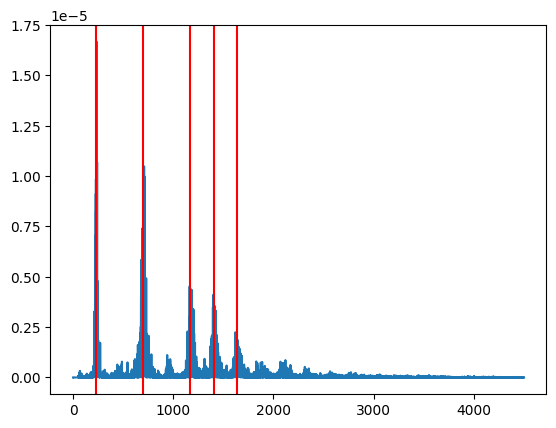

composantes fréquentielles du son :  [234.0, 702.0, 1170.0, 1404.0, 1638.0]
unique note de la gamme tempérée :  234.0


In [16]:
f_l = []
x,y = periodogramme(data_vuvu, Fs)
new_x = [i for i in x]
ind = new_x.index(4500)
cut_x = [i for i in x[0:ind]]
cut_y = [i for i in y[0:ind]]

note = cut_x[cut_y.index(np.amax(cut_y))]

plt.plot(cut_x,cut_y)
harmonics = [1,3,5,6,7]
for i in harmonics:
    plt.axvline(x = note * i, color = 'r', label = 'Note')
    f_l.append(note * i)
plt.show()

print("composantes fréquentielles du son : ", f_l)
print("unique note de la gamme tempérée : ", note)

## Filtre rejecteur RLC

Dans un premier temps, nous allons considérer le rejecteur RLC suivant :

<figure style="padding:40px;align:center">
<img style="width: 250px" src="./img/RLC.png">
<figcaption style='text-align:center;padding-top:20px;font-style: italic;'>Fig. Filtre RLC</figcaption>
</figure>

**Question 4.** Analyse du Filtre

* Déterminez la fonction de transfert $H(p)$ de ce rejecteur.
* Déterminez l’expression du coefficient d’amortissement m et de la pulsation propre ω0 en fonction des différents composants du filtre.
* A partir d’une analyse théorique, déterminez les pôles et les zeros de ce filtre. Montrez ensuite que ce filtre permet de supprimer complètement une composante fréquentielle f particulière (expression de f à déterminer). Déterminez théoriquement l’expression de la largeur de la bande rejetée à −3dB, puis l’expression du gain en basse-et haute fréquence de ce filtre.
* En utilisant Python, réalisez une étude complète de ce filtre (réponse indicielle, réponse fréquentielle).

**Rejecteur:**

$$\dfrac{T_0 \left(\frac{1}{\omega_0^2}p^2 + 1\right)}{\frac{1}{\omega_0²}p^2 + \frac{2.m}{\omega_0}.p +1}$$


**Fonction de Transfert:**

Impédance équivalente:
$$Z_{LC} = Z_L + Z_C = Lp + \frac1{Cp} = \dfrac{LC.p^2 +1}{C.p}$$

Fonction de Transfert:
\begin{equation}
    H(p) = \dfrac{Z_{LC}}{Z_{LC} + Z_R} \\
    \Leftrightarrow
    \boxed{ H(p) = \dfrac{LC.p^2 + 1}{LC.p^2 + RC.p +1}}
\end{equation}


**Identification:**

On remarque que pour ce filtre $T_0 = 1$. On procède ainsi à déterminer les expressions de $m$, $\omega_0$ et $\Delta \omega$:

\begin{equation}
    \boxed{
        \omega_0 = \dfrac{1}{\sqrt{LC}} \\
        m = \dfrac{RC}{2\sqrt{LC}} \\
        \Delta \omega = \dfrac{R}{L}
        }
\end{equation}

**Pôles :**

Pour déterminer les pôles, on détermine les racines du dénominateur de la fonction de transfert :
$$ LC.p^2 + RC.p + 1 = 0 $$

On calcul le discriminant :
$$ \Delta = (RC)^2 - 4LC $$

Alors, on obtient comme pôles :
\begin{equation}
    \boxed{
        p_1 = \frac{-RC + \sqrt{(RC)^2 - 4LC}}{2LC} \\
        p_2 = \frac{-RC - \sqrt{(RC)^2 - 4LC}}{2LC}
        }
\end{equation}


**Zéros :**

Pour déterminer les zéros, on détermine les racines du numération de la fonction de transfert :
$$ LC.p^2 + 1 $$

On calcul le discriminant :
$$ \Delta = -4LC < 0 $$

Alors, on obtient comme zéros :
\begin{equation}
    \boxed{
        z_1 = j \frac{1}{\sqrt{LC}} \\
        z_2 = - j \frac{1}{\sqrt{LC}}
        }
\end{equation}


**Composante fréquentielle f particulière :**

On sait que :
$$ \omega_0 = \frac 1{\sqrt{LC}} \leftrightarrow \omega_0 = 2 \pi f_0 $$

On a alors :
$$ \boxed{f_0 = \frac 1 {2 \pi \sqrt{LC}}} $$


**Largeur de la bande rejetée à −3dB :**
\begin{equation}
    \boxed{
        \Delta \omega = 2m\omega_0  \Leftrightarrow  \Delta \omega = \dfrac{R}{L} \\
        \Delta f = 2mf_0   \Leftrightarrow   \Delta f = \dfrac{R}{2 \pi L}
        }
\end{equation}

**Expression du gain en basse fréquence de ce filtre :**


**Expression du gain en haute fréquence de ce filtre :**

**Etude du filtre avec Python**
1. Réponse indicielle :
2. Réponse fréquentielle :

**Etude complète de ce filtre :**

**Question 5.** Analyse de la mise en cascade (Python/ LT-spice)

Pour supprimer les différentes composantes fréquentielles du Vuvuzela, nous allons cascader plusieurs rejecteurs RLC en série.

* Sous l’hypothèse que $R = R_1 = \cdots = R_L$ et que le coefficient d'amortissement $m$ est égal pour chaque étage RLC, réalisez un script python pour déterminer automatiquement les valeurs des composants $L$ et $C$ de chaque étage. Ces valeurs seront déterminées de manière à filtrer les différentes composantes fréquentielles $f_l$.
* Câblez le filtre cascadé sous LT-spice.
* Analysez la réponse fréquentielle du filtre cascadé.
* En utilisant les fonctionnalités audio de LT-spice, importez le fichier sonore vuvuzela.wav puis sauvegardez le signal de sortie dans un fichier sonore au format `wav`. Modifiez votre valeur de m de manière à obtenir un résultat sonore acceptable.

**Question 6.**

* En renseignant le paramètre série résistance de la bobine, expliquez la problématique liée à ce type de filtre.
* Effectuer une recherche pour trouver les schémas permettant de compenser cette résistance de la branche inductive.
* Critiquer le choix de ce filtre.

## Filtre rejecteur Twin-T

Pour éviter d’utiliser plusieurs bobines, nous allons maintenant considérer un filtre rejecteur Twin-T passif. Ce filtre est décrit dans la figure suivante :

<figure style="padding:40px;align:center">
<img style="width: 250px" src="./img/twinT.png">
<figcaption style='text-align:center;padding-top:20px;font-style: italic;'>Fig. Filtre Twin-T</figcaption>
</figure>

**Question 7.** Analyse du Filtre

* Similaire à la question 4.



**Question 8.** Analyse de la mise en cascade (Python/ LT-spice)

* Similaire à la question 5.



**Question 9.** 

* Critiquer le choix de ce filtre.

## Filtre rejecteur Twin-T actif

Le filtre précédent ne permet pas d'obtenir des résultats sonores satisfaisants. Pour améliorer le résultat sonore, il est possible d'utiliser un filtre Twin-T actif. Contrairement au filtre Twin-T passif, le filtre Twin-T actif permet le contrôle du coefficient d'amortissement $m$. Le tutoriel [MT-225 d’Analog Devices](https://www.analog.com/media/en/training-seminars/tutorials/MT-225.pdf) décrit la structure de ce filtre et donne plusieurs recommandations pour choisir les composants.

**Question 10.** Analyse du Filtre

* Similaire à la question 4.



**Question 11.** Analyse de la mise en cascade (Python/ LT-spice)

* Similaire à la question 5.



**Question 12.** 

* Critiquer le choix de ce filtre.